# CSE527 Homework 4
**Due date: 23:59 on Nov. 5, 2019 (Thuesday)**

In this semester, we will use Google Colab for the assignments, which allows us to utilize resources that some of us might not have in their local machines such as GPUs. You will need to use your Stony Brook (*.stonybrook.edu) account for coding and Google Drive to save your results.

## Google Colab Tutorial
---
Go to https://colab.research.google.com/notebooks/, you will see a tutorial named "Welcome to Colaboratory" file, where you can learn the basics of using google colab.

Settings used for assignments: ***Edit -> Notebook Settings -> Runtime Type (Python 3)***.


## Description
---
This project is an introduction to deep learning tools for computer vision. You will design and train deep convolutional networks for scene recognition using [PyTorch](http://pytorch.org). You can visualize the
structure of the network with [mNeuron] (http://vision03.csail.mit.edu/cnn_art/index.html)

Remember Homework 3: Scene recognition with bag of words. You worked hard to design a bag of features representations that achieved 60% to 70% accuracy (most likely) on 16-way scene classification. We're going to attack the same task with deep learning and get higher accuracy. Training from scratch won't work quite as well as homework 3 due to the insufficient amount of data, fine-tuning an existing network will work much better than homework 3.

In Problem 1 of the project you will train a deep convolutional network from scratch to recognize scenes. The starter codes gives you methods to load data and display them. You will need to define a simple network architecture and add jittering, normalization, and regularization to increase recognition accuracy to 50, 60, or perhaps 70%. Unfortunately, we only have 2,400 training examples so it doesn't seem possible to train a network from scratch which outperforms hand-crafted features

For Problem 2 you will instead fine-tune a pre-trained deep network to achieve about 85% accuracy on the task. We will use the pretrained AlexNet network which was not trained to recognize scenes at all. 

These two approaches represent the most common approaches to recognition problems in computer vision today -- train a deep network from scratch if you have enough data (it's not always obvious whether or not you do), and if you cannot then instead fine-tune a pre-trained network.

There are 2 problems in this homework with a total of 110 points including 10 bonus points. Be sure to read **Submission Guidelines** below. They are important. For the problems requiring text descriptions, you might want to add a markdown block for that.

## Dataset
---
Save the [dataset(click me)](https://drive.google.com/open?id=1NWC3TMsXSWN2TeoYMCjhf2N1b-WRDh-M) into your working folder in your Google Drive for this homework. <br>
Under your root folder, there should be a folder named "data" (i.e. XXX/Surname_Givenname_SBUID/data) containing the images.
**Do not upload** the data subfolder before submitting on blackboard due to size limit. There should be only one .ipynb file under your root folder Surname_Givenname_SBUID.

## Some Tutorials (PyTorch)
---
- You will be using PyTorch for deep learning toolbox (follow the [link](http://pytorch.org) for installation).
- For PyTorch beginners, please read this [tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) before doing your homework.
- Feel free to study more tutorials at http://pytorch.org/tutorials/.
- Find cool visualization here at http://playground.tensorflow.org.


## Starter Code
---
In the starter code, you are provided with a function that loads data into minibatches for training and testing in PyTorch.

In [0]:
# import packages here
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random 
import time
import datetime
from scipy import stats

import torch
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
# Set your working directory (in your google drive)
# Note that 'gdrive/My Drive/Y2019Fall/CSE-527-Intro-To-Computer-Vision/hw4' is just an example, 
#   change it to your specific homework directory.
cd '/content/gdrive/My Drive/Sharma_Gaurav_112680958_hw4'

/content/gdrive/My Drive/Sharma_Gaurav_112680958_hw4


In [94]:
# ==========================================
#    Load Training Data and Testing Data
# ==========================================
class_names = [name[13:] for name in glob.glob('./data/train/*')]
class_names = dict(zip(range(len(class_names)), class_names))
print("class_names: %s " % class_names)
n_train_samples = 150
n_test_samples = 50


def img_norm(img):
  #
  # Write your code here
  # normalize img pixels to [-1, 1]
  return(2.*(img - np.min(img))/np.ptp(img)-1)
  #img = cv2.normalize(img, None, alpha=-1, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
  return img;
  #

def load_dataset(path, img_size, num_per_class=-1, batch_num=1, shuffle=False, augment=False, is_color=False,
                img_rot=False, zero_centered=False):
    
    data = []
    labels = []
    
    if is_color:
        channel_num = 3
    else:
        channel_num = 1
        
    # read images and resizing
    for id, class_name in class_names.items():
        print("Loading images from class: %s" % id)
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            if is_color:
                img = cv2.imread(filename)
            else:
                img = cv2.imread(filename, 0)
            
            # resize the image
            img = cv2.resize(img, img_size, cv2.INTER_LINEAR)
            
            if is_color:
                img = np.transpose(img, [2, 0, 1])
            
            # norm pixel values to [-1, 1]
            data.append(img_norm(img))            
    #
    # Write your Data Augmentation code here
    # mirroring
    if augment:
      for id, class_name in class_names.items():
          print("Loading images from class: %s" % id)
          img_path_class = glob.glob(path + class_name + '/*.jpg')
          if num_per_class > 0:
              img_path_class = img_path_class[:num_per_class]
          labels.extend([id]*len(img_path_class))
          for filename in img_path_class:
              if is_color:
                  img = cv2.imread(filename)
              else:
                  img = cv2.imread(filename, 0)
              
              # resize the image
              img = cv2.resize(img, img_size, cv2.INTER_LINEAR)
              
              if is_color:
                  img = np.transpose(img, [2, 0, 1])
              
              # norm pixel values to [-1, 1]
              img = img_norm(img)
              img = cv2.flip(img,1)
              data.append(img)
    
    if img_rot:
      for id, class_name in class_names.items():
          print("Loading images from class: %s" % id)
          img_path_class = glob.glob(path + class_name + '/*.jpg')
          if num_per_class > 0:
              img_path_class = img_path_class[:num_per_class]
          labels.extend([id]*len(img_path_class))
          for filename in img_path_class:
              if is_color:
                  img = cv2.imread(filename)
              else:
                  img = cv2.imread(filename, 0)
              
              # resize the image
              img = cv2.resize(img, img_size, cv2.INTER_LINEAR)
              
              if is_color:
                  img = np.transpose(img, [2, 0, 1])
            
              # norm pixel values to [-1, 1]
              if np.random.choice([1,0]):
                img = img_norm(img)
                img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
                data.append(img)
    
    #
    # Write your Data Normalization code here
    # norm data to zero-centered
    # 
    if zero_centered:
      print("Zero centering the image")      
      data = data - np.mean(data)

    '''  
    if zero_centered:
      for imgs in data:
        imgs = np.subtract(imgs,np.array(np.mean(imgs))) # the -= means can be read as x = x- np.mean(x)
        imgs = np.array(np.divide(imgs,np.std(imgs))) # the /= means can be read as x = x/np.std(x)  
    '''        
    # randomly permute (this step is important for training)
    if shuffle:
        bundle = list(zip(data, labels))
        random.shuffle(bundle)
        data, labels = zip(*bundle)
    
    # divide data into minibatches of TorchTensors
    if batch_num > 1:
        batch_data = []
        batch_labels = []
        
        print(len(data))
        print(batch_num)
        
        for i in range(int(len(data) / batch_num)):
            minibatch_d = data[i*batch_num: (i+1)*batch_num]
            minibatch_d = np.reshape(minibatch_d, (batch_num, channel_num, img_size[0], img_size[1]))
            batch_data.append(torch.from_numpy(minibatch_d))

            minibatch_l = labels[i*batch_num: (i+1)*batch_num]
            batch_labels.append(torch.LongTensor(minibatch_l))
        data, labels = batch_data, batch_labels 
    
    return zip(batch_data, batch_labels)

class_names: {0: 'Forest', 1: 'Industrial', 2: 'Flower', 3: 'Coast', 4: 'InsideCity', 5: 'Office', 6: 'Bedroom', 7: 'Highway', 8: 'Street', 9: 'TallBuilding', 10: 'LivingRoom', 11: 'Suburb', 12: 'OpenCountry', 13: 'Mountain', 14: 'Kitchen', 15: 'Store'} 


In [95]:
# load data into size (64, 64)
img_size = (64, 64)
batch_num = 50 # training sample number per batch

# load training dataset
trainloader_small_no_enhancements = list(load_dataset('./data/train/', img_size, batch_num=batch_num, shuffle=True, 
                                      augment=False, zero_centered=False))

trainloader_small_augmented = list(load_dataset('./data/train/', img_size, batch_num=batch_num, shuffle=True, 
                                      augment=True, zero_centered=False))

trainloader_small_augmented_zero_centered = list(load_dataset('./data/train/', img_size, batch_num=batch_num, shuffle=True, 
                                      augment=True, zero_centered=True))

trainloader_small_augmented_zero_centered_rotated = list(load_dataset('./data/train/', img_size, batch_num=batch_num, shuffle=True, 
                                      augment=True, zero_centered=True, img_rot= True))

train_num = len(trainloader_small_no_enhancements)
print("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_num=batch_num))
test_num = len(testloader_small)
print("Finish loading %d minibatches(=%d) of testing samples." % (test_num, batch_num))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
2400
50
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Loading images from class: 0
Loading images from cla

Forest


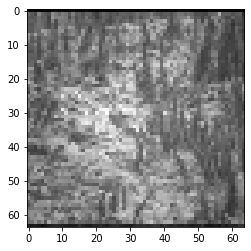

Coast


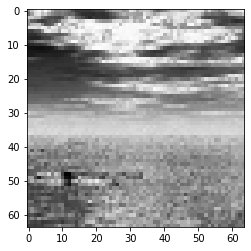

Suburb


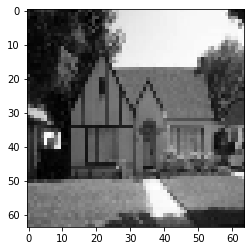

Forest


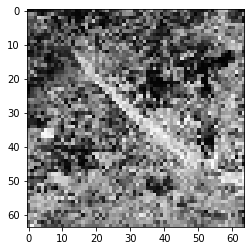

In [96]:
# show some images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if len(npimg.shape) > 2:
        npimg = np.transpose(img, [1, 2, 0])
    plt.figure
    plt.imshow(npimg, 'gray')
    plt.show()
img, label = trainloader_small_no_enhancements[0][0][11][0], trainloader_small_no_enhancements[0][1][11]
label = int(np.array(label))
print(class_names[label])
imshow(img)

img2, label2 = trainloader_small_augmented_zero_centered[0][0][11][0], trainloader_small_augmented_zero_centered[0][1][11]
label2 = int(np.array(label2))
print(class_names[label2])
imshow(img2)

img3, label3 = trainloader_small_augmented[0][0][11][0], trainloader_small_augmented[0][1][11]
label3 = int(np.array(label3))
print(class_names[label3])
imshow(img3)

img4, label4 = trainloader_small_augmented_zero_centered_rotated[0][0][11][0], trainloader_small_augmented_zero_centered_rotated[0][1][11]
label4 = int(np.array(label4))
print(class_names[label4])
imshow(img4)


## Problem 1: Training a Network From Scratch
{Part 1: 35 points} Gone are the days of hand designed features. Now we have end-to-end learning in which a highly non-linear representation is learned for our data to maximize our objective (in this case, 16-way classification accuracy). Instead of 70% accuracy we can now recognize scenes with... 25% accuracy. OK, that didn't work at all. Try to boost the accuracy by doing the following:

**Data Augmentation**: We don't have enough training data, let's augment the training data.
If you left-right flip (mirror) an image of a scene, it never changes categories. A kitchen doesn't become a forest when mirrored. This isn't true in all domains — a "d" becomes a "b" when mirrored, so you can't "jitter" digit recognition training data in the same way. But we can synthetically increase our amount of training data by left-right mirroring training images during the learning process.

After you implement mirroring, you should notice that your training error doesn't drop as quickly. That's actually a good thing, because it means the network isn't overfitting to the 2,400 original training images as much (because it sees 4,800 training images now, although they're not as good as 4,800 truly independent samples). Because the training and test errors fall more slowly, you may need more training epochs or you may try modifying the learning rate. You should see a roughly 10% increase in accuracy by adding mirroring. You are **required** to implement mirroring as data augmentation for this part.

You can try more elaborate forms of jittering -- zooming in a random amount, rotating a random amount, taking a random crop, etc. These are not required, you might want to try these in the bonus part.

**Data Normalization**: The images aren't zero-centered. One simple trick which can help a lot is to subtract the mean from every image. It would arguably be more proper to only compute the mean from the training images (since the test/validation images should be strictly held out) but it won't make much of a difference. After doing this you should see another 15% or so increase in accuracy. This part is **required**.

**Network Regularization**: Add dropout layer. If you train your network (especially for more than the default 30 epochs) you'll see that the training error can decrease to zero while the val top1 error hovers at 40% to 50%. The network has learned weights which can perfectly recognize the training data, but those weights don't generalize to held out test data. The best regularization would be more training data but we don't have that. Instead we will use dropout regularization.

What does dropout regularization do? It randomly turns off network connections at training time to fight overfitting. This prevents a unit in one layer from relying too strongly on a single unit in the previous layer. Dropout regularization can be interpreted as simultaneously training many "thinned" versions of your network. At test, all connections are restored which is analogous to taking an average prediction over all of the "thinned" networks. You can see a more complete discussion of dropout regularization in this [paper](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf).

The dropout layer has only one free parameter — the dropout rate — the proportion of connections that are randomly deleted. The default of 0.5 should be fine. Insert a dropout layer between your convolutional layers. In particular, insert it directly before your last convolutional layer. Your test accuracy should increase by another 10%. Your train accuracy should decrease much more slowly. That's to be expected — you're making life much harder for the training algorithm by cutting out connections randomly. 

If you increase the number of training epochs (and maybe decrease the learning rate) you should be able to achieve around 50% test accuracy. In this part, you are **required** to add dropout layer to your network.

Please give detailed descriptions of your network layout in the following format:<br>
Data augmentation: [descriptions]<br>
Data normalization: [descriptions]<br>
Layer 1: [layer_type]: [Parameters]<br>
Layer 2: [layer_type]: [Parameters]<br>
...<br>
Then report the final accuracy on test set and time consumed for training and testing separately.

{Part 2: 15 points} Try **three techniques** taught in the class to increase the accuracy of your model. Such as increasing training data by randomly rotating training images, adding batch normalization, different activation functions (e.g., sigmoid) and model architecture modification. Note that too many layers can do you no good due to insufficient training data. Clearly describe your method and accuracy increase/decrease for each of the three techniques.

In [0]:
# ==========================================
#       Define Network Architecture
# ==========================================
class Net(nn.Module):
  def __init__(self,dropout_flag = False, batch_norm = False, sigmoid_acti = False):
      super(Net, self).__init__()
      if dropout_flag:
        self.features = nn.Sequential(
            nn.Conv2d(1, 30, kernel_size=3, stride=1, padding=1),nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #nn.Dropout(p = 0.1),
            nn.Conv2d(30, 10, kernel_size=3, stride=1, padding=1),nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p = 0.05),
            nn.Conv2d(10, 10, kernel_size=3, stride=1, padding=1),nn.ReLU(),
            nn.Dropout(p = 0.05)
            )
        self.classifier = nn.Sequential(
        nn.Linear(16 * 16* 10, 1000),
        nn.Linear(1000, 16)
        )
      
      if batch_norm:
        self.features = nn.Sequential(
            nn.Conv2d(1, 30, kernel_size=3, stride=1, padding=1),nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(30),

            #nn.Dropout(p = 0.1),
            nn.Conv2d(30, 10, kernel_size=3, stride=1, padding=1),nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Dropout(p = 0.05),
            nn.BatchNorm2d(10),

            nn.Conv2d(10, 10, kernel_size=3, stride=1, padding=1),nn.ReLU(),
            nn.Dropout(p = 0.05),
            nn.BatchNorm2d(10),

            )
  
      if sigmoid_acti:
        self.features = nn.Sequential(
            nn.Conv2d(1, 30, kernel_size=3, stride=1, padding=1),nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #nn.Dropout(p = 0.1),
            nn.Conv2d(30, 10, kernel_size=3, stride=1, padding=1),nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p = 0.05),
            nn.Conv2d(10, 10, kernel_size=3, stride=1, padding=1),nn.Sigmoid(),
            nn.Dropout(p = 0.05)
            )
        self.classifier = nn.Sequential(
        nn.Linear(16 * 16* 10, 1000),
        nn.Linear(1000, 16)
        )
      if not(dropout_flag) and not(batch_norm) and not(sigmoid_acti):
        self.features = nn.Sequential(
            nn.Conv2d(1, 30, kernel_size=3, stride=1, padding=1),nn.ReLU(),
            nn.Conv2d(30, 10, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
            )
        self.classifier = nn.Sequential(
        nn.Linear(64 * 64 * 10, 1000),
        nn.Linear(1000, 16)
        )
  
  def forward(self, x):
    x = self.features(x)
    x = x.reshape(x.size(0), -1)
    x = self.classifier(x)
    return x
    
  def weights_init(self):
    for module in self.modules():
      if isinstance(module, nn.Conv2d):
        nn.init.normal_(module.weight, mean = 0, std = 1)
        nn.init.constant_(module.bias, 0)


In [0]:
import torch.optim as optim

def train_test(train_data, test_data, lr = 0.001, max_epoch = 30, dropout_flag = False, batch_norm = False, sigmoid_acti = False):
  net = Net(dropout_flag, batch_norm, sigmoid_acti)
  #net.weights_init()
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(net.parameters(), lr)
  net = net.cuda()

  start_time = time.time()

  for epoch in range(max_epoch):

        for i in range(len(train_data)):
            
            imgs = train_data[i][0].float().cuda()
            labels = train_data[i][1].cuda()

            outputs = net(imgs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            #print(predicted)
            correct = (predicted == labels).sum().item()
        print("Epoch %d done"%(epoch), end=' || ')
        print('Loss in this epoch: %f'%(loss.item()))

  print("\nTraining Done...\n")
  print("Time consumption for training in seconds : %s seconds" % (time.time() - start_time))
  ########## TESTING #########      
  correct = 0
  total = 0
  start_time = time.time()
  with torch.no_grad():
    for inputs, labels in test_data:
      inputs = inputs.float().cuda()
      labels = labels.cuda()
      outputs = net(inputs)
      _, predicted = torch.max(outputs.data, 1)
      predicted=predicted.cuda()

      #print('predicted',predicted)
      #print('labels = ',labels)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  print('Accuracy of the network: %d %%' % (
        100 * correct / total))

  print("Time consumption for testing in seconds : %s seconds" % (time.time() - start_time))

In [108]:
# ==========================================
#         Optimize/Train Network
# ==========================================
# ==========================================
#            Evaluating Network
# ==========================================

print("TRAINING DATA WITH NO ENHANCEMENTS")
print("\nTraining Initialized...\n")
train_test(trainloader_small_no_enhancements, testloader_small, lr = 0.001, max_epoch = 5, dropout_flag = False)

TRAINING DATA WITH NO ENHANCEMENTS

Training Initialized...

Epoch 0 done || Loss in this epoch: 104.049171
Epoch 1 done || Loss in this epoch: 50.424004
Epoch 2 done || Loss in this epoch: 23.266617
Epoch 3 done || Loss in this epoch: 10.173688
Epoch 4 done || Loss in this epoch: 3.813149

Training Done...

Time consumption for training in milliseconds: 587.911
Accuracy of the network: 27 %
Time consumption for testing in milliseconds: 97.975


In [109]:
print("TRAINING DATA WITH AUGMENT ENHANCEMENT")
print("\nTraining Initialized...\n")
train_test(trainloader_small_augmented, testloader_small, lr = 0.001, max_epoch = 5, dropout_flag = False)

TRAINING DATA WITH AUGMENT ENHANCEMENT

Training Initialized...

Epoch 0 done || Loss in this epoch: 21.694927
Epoch 1 done || Loss in this epoch: 2.197410
Epoch 2 done || Loss in this epoch: 0.433983
Epoch 3 done || Loss in this epoch: 0.012274
Epoch 4 done || Loss in this epoch: 0.360602

Training Done...

Time consumption for training in milliseconds: 541.979
Accuracy of the network: 41 %
Time consumption for testing in milliseconds: 98.968


In [116]:
print("TRAINING DATA WITH AUGMENT AND ZERO CENTERED ENHANCEMENT")
print("\nTraining Initialized...\n")
train_test(trainloader_small_augmented_zero_centered, testloader_small, lr = 0.001, max_epoch = 5, dropout_flag = False)

TRAINING DATA WITH AUGMENT AND ZERO CENTERED ENHANCEMENT

Training Initialized...

Epoch 0 done || Loss in this epoch: 84.924202
Epoch 1 done || Loss in this epoch: 28.163681
Epoch 2 done || Loss in this epoch: 16.949974
Epoch 3 done || Loss in this epoch: 3.548278
Epoch 4 done || Loss in this epoch: 0.991414

Training Done...

Time consumption for training in milliseconds: 477.919
Accuracy of the network: 42 %
Time consumption for testing in milliseconds: 98.048


In [205]:
print("\n")
print("TRAINING DATA WITH BOTH ENHANCEMENTS AND REGULARIZATION")
print("\nTraining Initialized...\n")
train_test(trainloader_small_augmented_zero_centered, testloader_small, lr = 0.001, max_epoch =20, dropout_flag = True)



TRAINING DATA WITH BOTH ENHANCEMENTS AND REGULARIZATION

Training Initialized...

Epoch 0 done || Loss in this epoch: 2.098276
Epoch 1 done || Loss in this epoch: 1.727459
Epoch 2 done || Loss in this epoch: 1.238506
Epoch 3 done || Loss in this epoch: 1.108287
Epoch 4 done || Loss in this epoch: 0.744189
Epoch 5 done || Loss in this epoch: 0.512278
Epoch 6 done || Loss in this epoch: 0.510355
Epoch 7 done || Loss in this epoch: 0.458473
Epoch 8 done || Loss in this epoch: 0.462687
Epoch 9 done || Loss in this epoch: 0.234283
Epoch 10 done || Loss in this epoch: 0.309121
Epoch 11 done || Loss in this epoch: 0.478782
Epoch 12 done || Loss in this epoch: 0.153786
Epoch 13 done || Loss in this epoch: 0.059464
Epoch 14 done || Loss in this epoch: 0.114835
Epoch 15 done || Loss in this epoch: 0.177958
Epoch 16 done || Loss in this epoch: 0.284920
Epoch 17 done || Loss in this epoch: 0.289742
Epoch 18 done || Loss in this epoch: 0.092088
Epoch 19 done || Loss in this epoch: 0.067064

Train

# Question 1, Part 1
**BASE CASE: Without any enhancement**
- **epochs** - 5
- **Accuracy** of the network: 27 %
- **Time consumption for training** in milliseconds: 587.911
- **Time consumption for testing** in milliseconds: 97.975
- **MODEL ARCHITECTURE:**
- **layer 1:** convolutional, input channels - 1, input channels - 30, kernel_size=3, stride=1, padding=1
- **layer 2:** relu activation
- **layer 3:** convolutional, input channels - 30, input channels - 10, kernel_size=3, stride=1, padding=1
- **layer 4:** relu activation
- **layer 5:** Linear kernel, input - 64 * 64 * 10, output - 1000
- **layer 6:** Linear kernel, input - 1000, output - 16

**1. Data Augmentation**

- Data Augmented using flipped image.
- **epochs** - 5
- **Accuracy** of the network: 41 %
- **Time consumption for training** in milliseconds: 541.979
- **Time consumption for testing** in milliseconds: 98.968
- **MODEL ARCHITECTURE:**
- **layer 1:** convolutional, input channels - 1, input channels - 30, kernel_size=3, stride=1, padding=1
- **layer 2:** relu activation
- **layer 3:** convolutional, input channels - 30, input channels - 10, kernel_size=3, stride=1, padding=1
- **layer 4:** relu activation
- **layer 5:** Linear kernel, input - 64 * 64 * 10, output - 1000
- **layer 6:** Linear kernel, input - 1000, output - 16

**2. Data Normalization**
- Data from the first part normalized
- **epochs** - 5
- **Accuracy** of the network: 42 %
- **Time consumption for training** in milliseconds: 477.919
- **Time consumption for testing** in milliseconds: 98.048
- **MODEL ARCHITECTURE:**
- **layer 1:** convolutional, input channels - 1, input channels - 30, kernel_size=3, stride=1, padding=1
- **layer 2:** relu activation
- **layer 3:** convolutional, input channels - 30, input channels - 10, kernel_size=3, stride=1, padding=1
- **layer 4:** relu activation
- **layer 5:** Linear kernel, input - 64 * 64 * 10, output - 1000
- **layer 6:** Linear kernel, input - 1000, output - 16

**3. Network Regularization**
- Data from the first part normalized
- **epochs** - 20
- **Accuracy** of the network: 52 %
- **Time consumption for training** in milliseconds: 280.593
- **Time consumption for testing** in milliseconds: 32.152
- **MODEL ARCHITECTURE:**
- **layer 1:** convolutional, input channels - 1, input channels - 30, kernel_size=3, stride=1, padding=1
- **layer 2:** relu activation
- **layer 3:** Max Pool Layer with kernel size - 2 and stride - 2
- **layer 4:** convolutional, input channels - 30, input channels - 10, kernel_size=3, stride=1, padding=1
- **layer 5:** relu activation
- **layer 6:** Dropout layer with p = 0.05
- **layer 7:** convolutional, input channels - 10, input channels - 10, kernel_size=3, stride=1, padding=1
- **layer 8:** relu activation
- **layer 9:** Dropout layer with p = 0.05
- **layer 10:** Linear kernel, input - 16 * 16 * 10, output - 1000
- **layer 11:** Linear kernel, input - 1000, output - 16

In [259]:
print("TRAINING DATA WITH BATCH NORMALIZATION")
print("\nTraining Initialized...\n")
train_test(trainloader_small_augmented_zero_centered, testloader_small, lr = 0.001, max_epoch = 20, dropout_flag = False, batch_norm = True)


TRAINING DATA WITH BATCH NORMALIZATION

Training Initialized...

Epoch 0 done || Loss in this epoch: 1.438013
Epoch 1 done || Loss in this epoch: 1.175648
Epoch 2 done || Loss in this epoch: 0.864382
Epoch 3 done || Loss in this epoch: 0.420234
Epoch 4 done || Loss in this epoch: 0.501175
Epoch 5 done || Loss in this epoch: 0.563837
Epoch 6 done || Loss in this epoch: 0.195906
Epoch 7 done || Loss in this epoch: 0.412826
Epoch 8 done || Loss in this epoch: 0.104115
Epoch 9 done || Loss in this epoch: 0.189219
Epoch 10 done || Loss in this epoch: 0.065039
Epoch 11 done || Loss in this epoch: 0.055122
Epoch 12 done || Loss in this epoch: 0.035021
Epoch 13 done || Loss in this epoch: 0.111231
Epoch 14 done || Loss in this epoch: 0.053639
Epoch 15 done || Loss in this epoch: 0.143239
Epoch 16 done || Loss in this epoch: 0.318497
Epoch 17 done || Loss in this epoch: 0.172990
Epoch 18 done || Loss in this epoch: 0.074578
Epoch 19 done || Loss in this epoch: 0.028710

Training Done...

Time c

In [272]:

print("TRAINING DATA WITH AUGMENT, ZERO CENTERED AND ROTATED ENHANCEMENT")
print("\nTraining Initialized...\n")
train_test(trainloader_small_augmented_zero_centered_rotated, testloader_small, lr = 0.001, max_epoch = 30, dropout_flag = True)

TRAINING DATA WITH AUGMENT, ZERO CENTERED AND ROTATED ENHANCEMENT

Training Initialized...

Epoch 0 done || Loss in this epoch: 2.103231
Epoch 1 done || Loss in this epoch: 1.573830
Epoch 2 done || Loss in this epoch: 1.301090
Epoch 3 done || Loss in this epoch: 1.237253
Epoch 4 done || Loss in this epoch: 1.116654
Epoch 5 done || Loss in this epoch: 0.887600
Epoch 6 done || Loss in this epoch: 0.840466
Epoch 7 done || Loss in this epoch: 0.654081
Epoch 8 done || Loss in this epoch: 0.523428
Epoch 9 done || Loss in this epoch: 0.469818
Epoch 10 done || Loss in this epoch: 0.560107
Epoch 11 done || Loss in this epoch: 0.490822
Epoch 12 done || Loss in this epoch: 0.679084
Epoch 13 done || Loss in this epoch: 0.317107
Epoch 14 done || Loss in this epoch: 0.388118
Epoch 15 done || Loss in this epoch: 0.474732
Epoch 16 done || Loss in this epoch: 0.549622
Epoch 17 done || Loss in this epoch: 0.241377
Epoch 18 done || Loss in this epoch: 0.366311
Epoch 19 done || Loss in this epoch: 0.19287

In [268]:
print("TRAINING DATA WITH SIGMOID ACTIVATION FUNCTION")
print("\nTraining Initialized...\n")
train_test(trainloader_small_augmented_zero_centered_rotated, testloader_small, lr = 0.001, max_epoch = 20, sigmoid_acti = True)

TRAINING DATA WITH SIGMOID ACTIVATION FUNCTION

Training Initialized...

Epoch 0 done || Loss in this epoch: 2.764077
Epoch 1 done || Loss in this epoch: 2.730694
Epoch 2 done || Loss in this epoch: 2.727096
Epoch 3 done || Loss in this epoch: 2.721369
Epoch 4 done || Loss in this epoch: 2.708658
Epoch 5 done || Loss in this epoch: 2.615410
Epoch 6 done || Loss in this epoch: 2.512267
Epoch 7 done || Loss in this epoch: 2.463761
Epoch 8 done || Loss in this epoch: 2.439942
Epoch 9 done || Loss in this epoch: 2.435693
Epoch 10 done || Loss in this epoch: 2.404415
Epoch 11 done || Loss in this epoch: 2.323920
Epoch 12 done || Loss in this epoch: 2.322871
Epoch 13 done || Loss in this epoch: 2.296264
Epoch 14 done || Loss in this epoch: 2.247626
Epoch 15 done || Loss in this epoch: 2.225130
Epoch 16 done || Loss in this epoch: 2.182197
Epoch 17 done || Loss in this epoch: 2.173429
Epoch 18 done || Loss in this epoch: 2.130766
Epoch 19 done || Loss in this epoch: 2.077478

Training Done...

# Question 1, Part 2

**1. Adding batch normalization to network**
- Batch Normalization to the network.
- Accuracy of the network: 41 %
- Time consumption for training in milliseconds: 360.694
- Time consumption for testing in milliseconds: 73.773
- **MODEL ARCHITECTURE:**
- **layer 1:** convolutional, input channels - 1, input channels - 30, kernel_size=3, stride=1, padding=1
- **layer 2:** relu activation
- **layer 3:** Max Pool Layer with kernel size - 2 and stride - 2
- **layer 4 :** Batch Normalization Layer
- **layer 5:** convolutional, input channels - 30, input channels - 10, kernel_size=3, stride=1, padding=1
- **layer 6:** relu activation
- **layer 7:** Max Pool Layer with kernel size - 2 and stride - 2
- **layer 8:** Dropout layer with p = 0.05
- **layer 9:** Batch Normalization Layer
- **layer 10:** convolutional, input channels - 10, input channels - 10, kernel_size=3, stride=1, padding=1
- **layer 11:** relu activation
- **layer 12:** Dropout layer with p = 0.05
- **layer 13:** Batch Normalization Layer
- **layer 14:** Linear kernel, input - 16 * 16 * 10, output - 1000
- **layer 15:** Linear kernel, input - 1000, output - 16

**2. Results after rotated image data appending (that too randomly)**
- Addition of rotated images the dataset.
- Accuracy of the network: 48 %
- Time consumption for training in milliseconds: 577.649
- Time consumption for testing in milliseconds: 32.205
- **MODEL ARCHITECTURE:**
- **layer 1:** convolutional, input channels - 1, input channels - 30, kernel_size=3, stride=1, padding=1
- **layer 2:** relu activation
- **layer 3:** Max Pool Layer with kernel size - 2 and stride - 2
- **layer 4:** convolutional, input channels - 30, input channels - 10, kernel_size=3, stride=1, padding=1
- **layer 5:** relu activation
- **layer 6:** Dropout layer with p = 0.05
- **layer 7:** convolutional, input channels - 10, input channels - 10, kernel_size=3, stride=1, padding=1
- **layer 8:** relu activation
- **layer 9:** Dropout layer with p = 0.05
- **layer 10:** Linear kernel, input - 16 * 16 * 10, output - 1000
- **layer 11:** Linear kernel, input - 1000, output - 16

**3. Results after changing activation function to Sigmoid**
- Activation function changed to Sigmoid.
- Accuracy of the network: 34 %
- Time consumption for training in milliseconds: 890.858
- Time consumption for testing in milliseconds: 32.403
- **MODEL ARCHITECTURE:**
- **layer 1:** convolutional, input channels - 1, input channels - 30, kernel_size=3, stride=1, padding=1
- **layer 2:** sigmoid activation
- **layer 3:** Max Pool Layer with kernel size - 2 and stride - 2
- **layer 4:** convolutional, input channels - 30, input channels - 10, kernel_size=3, stride=1, padding=1
- **layer 5:** sigmoid activation
- **layer 6:** Dropout layer with p = 0.05
- **layer 7:** convolutional, input channels - 10, input channels - 10, kernel_size=3, stride=1, padding=1
- **layer 8:** sigmoid activation
- **layer 9:** Dropout layer with p = 0.05
- **layer 10:** Linear kernel, input - 16 * 16 * 10, output - 1000
- **layer 11:** Linear kernel, input - 1000, output - 16

## Problem 2: Fine Tuning a Pre-Trained Deep Network
{Part 1: 30 points} Our convolutional network to this point isn't "deep". Fortunately, the representations learned by deep convolutional networks is that they generalize surprisingly well to other recognition tasks. 

But how do we use an existing deep network for a new recognition task? Take for instance,  [AlexNet](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks) network has 1000 units in the final layer corresponding to 1000 ImageNet categories.

**Strategy A**: One could use those 1000 activations as a feature in place of a hand crafted feature such as a bag-of-features representation. You would train a classifier (typically a linear SVM) in that 1000 dimensional feature space. However, those activations are clearly very object specific and may not generalize well to new recognition tasks. It is generally better to use the activations in slightly earlier layers of the network, e.g. the 4096 activations in the last 2nd fully-connected layer. You can often get away with sub-sampling those 4096 activations considerably, e.g. taking only the first 200 activations. 

**Strategy B**: *Fine-tune* an existing network. In this scenario you take an existing network, replace the final layer (or more) with random weights, and train the entire network again with images and ground truth labels for your recognition task. You are effectively treating the pre-trained deep network as a better initialization than the random weights used when training from scratch. When you don't have enough training data to train a complex network from scratch (e.g. with the 16 classes) this is an attractive option. Fine-tuning can work far better than Strategy A of taking the activations directly from an pre-trained CNN. For example, in [this paper](http://www.cc.gatech.edu/~hays/papers/deep_geo.pdf) from CVPR 2015, there wasn't enough data to train a deep network from scratch, but fine tuning led to 4 times higher accuracy than using off-the-shelf networks directly.

You are required to implement **Strategy B** to fine-tune a pre-trained **AlexNet** for this scene classification task. You should be able to achieve performance of 85% approximately. It takes roughly 35~40 minutes to train 20 epoches with AlexNet.

Please provide detailed descriptions of:<br>
(1) which layers of AlexNet have been replaced<br>
(2) the architecture of the new layers added including activation methods (same as problem 1)<br>
(3) the final accuracy on test set along with time consumption for both training and testing <br>

{Part 2: 20 points} Implement Strategy A where you use the activations of the pre-trained network as features to train one-vs-all SVMs for your scene classification task. Report the final accuracy on test set along with time consumption for both training and testing.

{Bonus: 10 points} Bonus will be given to those who fine-tune the [VGG network](https://pytorch.org/docs/stable/_modules/torchvision/models/vgg.html) [paper](https://arxiv.org/pdf/1409.1556.pdf) and compare performance with AlexNet. Explain why VGG performed better or worse.

**Hints**:
- Many pre-trained models are available in PyTorch at [here](http://pytorch.org/docs/master/torchvision/models.html).
- For fine-tuning pretrained network using PyTorch, please read this [tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

In [275]:
# reload data with a larger size
img_size = (224, 224)
batch_num = 50 # training sample number per batch 

# load training dataset
trainloader_large = list(load_dataset('./data/train/', img_size, batch_num=batch_num, shuffle=True, 
                                      augment=False, is_color=True, zero_centered=True))
train_num = len(trainloader_large)
print("Finish loading %d minibatches(=%d) of training samples." % (train_num, batch_num))

# load testing dataset
testloader_large = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_num=batch_num, is_color=True))
test_num = len(testloader_large)
print("Finish loading %d minibatches(=%d) of testing samples." % (test_num, batch_num))

Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Zero centering the image
2400
50
Finish loading 48 minibatches(=50) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
L

In [0]:
def train_test_alexnet(model_alexnet, train_data, test_data, lr = 0.001, max_epoch = 30):

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model_alexnet.parameters(), lr)

  start_time = time.time()

  for epoch in range(max_epoch):

        for i in range(len(train_data)):
            
            imgs = train_data[i][0].float().cuda()
            labels = train_data[i][1].cuda()

            outputs = model_alexnet(imgs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total = labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            #print(predicted)
            correct = (predicted == labels).sum().item()
        print("Epoch %d done"%(epoch), end=' || ')
        print('Loss in this epoch: %f'%(loss.item()))

  print("\nTraining Done...\n")
  print("Time consumption for training in seconds : %s seconds"%(time.time()-start_time)) 
 ########## TESTING #########      
  correct = 0
  total = 0
  start_time = time.time()
  with torch.no_grad():
    for inputs, labels in test_data:
      inputs = inputs.float().cuda()
      labels = labels.cuda()
      outputs = model_alexnet(inputs)
      _, predicted = torch.max(outputs.data, 1)
      predicted=predicted.cuda()

      #print('predicted',predicted)
      #print('labels = ',labels)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  print('Accuracy of the network: %d %%' % (
        100 * correct / total))
  print("Time consumption for training in seconds : %s seconds"%(time.time()-start_time)) 


In [304]:
# ==========================================
#       Fine-Tune Pretrained Network
# ==========================================
from torchvision.models import alexnet

model_alexnet = alexnet(pretrained=True)
model_alexnet.classifier[-1]=nn.Linear(4096, 16, bias=True)
model_alexnet = model_alexnet.cuda()
train_test_alexnet(model_alexnet, trainloader_large, testloader_large, max_epoch = 15)


Epoch 0 done || Loss in this epoch: 1.081728
Epoch 1 done || Loss in this epoch: 0.746149
Epoch 2 done || Loss in this epoch: 0.574308
Epoch 3 done || Loss in this epoch: 0.599259
Epoch 4 done || Loss in this epoch: 0.480816
Epoch 5 done || Loss in this epoch: 0.378518
Epoch 6 done || Loss in this epoch: 0.436249
Epoch 7 done || Loss in this epoch: 0.363689
Epoch 8 done || Loss in this epoch: 0.262549
Epoch 9 done || Loss in this epoch: 0.305896
Epoch 10 done || Loss in this epoch: 0.298497
Epoch 11 done || Loss in this epoch: 0.337864
Epoch 12 done || Loss in this epoch: 0.294874
Epoch 13 done || Loss in this epoch: 0.232991
Epoch 14 done || Loss in this epoch: 0.199409

Training Done...

Time consumption for training in seconds : 79.20733761787415 seconds
Accuracy of the network: 83 %
Time consumption for training in seconds : 0.3462963104248047 seconds


In [0]:
alexnet_to_be_changed = alexnet(pretrained=True)

alexnet_to_be_changed.classifier = nn.Sequential(*list(alexnet_to_be_changed.classifier.children())[:-1])

features_to_extracted=[]
with torch.no_grad():
    for i in range(len(trainloader_large)):
        imgs = trainloader_large[i][0].float()
        labels = trainloader_large[i][1]
        outputs = alexnet_to_be_changed(imgs)
        features_to_extracted.append(outputs)

features_to_extracted_test=[]
with torch.no_grad():
    for i in range(len(testloader_large)):
        imgs = testloader_large[i][0].float()
        labels = testloader_large[i][1]
        outputs = alexnet_to_be_changed(imgs)
        features_to_extracted_test.append(outputs)

samples_for_svm = 1000
train_X=[]
for data_img in features_to_extracted:
  for img_features in data_img:
    train_X.append(img_features[:samples_for_svm].tolist())

test_X=[]
for data_img in features_to_extracted_test:
  for img_features in data_img:
    test_X.append(img_features[:samples_for_svm].tolist())

train_Y=[]
for data_img in trainloader_large:
  for img in data_img[1]:
    train_Y.append(int(img.data))

test_Y=[]
for data_img in testloader_large:
  for img in data_img[1]:
    test_Y.append(int(img.data))

In [317]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

clf = LinearSVC(random_state=1, C=0.001)

start_time =time.time()
clf.fit(train_X, train_Y)
print("Time consumption for training: %s seconds" %(time.time()-start_time))

start_time = time.time()
predictions =clf.predict(test_X)
print("Time consumption for testing: %s seconds" %(time.time()-start_time))

print("Accuracy: ",accuracy_score(predictions, test_Y)*100)


Time consumption for training: 0.2742161750793457 seconds
Time consumption for testing: 0.020309925079345703 seconds
Accuracy:  80.25


In [318]:
############ VGG MODEL ###############
# ==========================================
#       Fine-Tune Pretrained Network
# ==========================================
from torchvision.models import vgg16

model_VGG = vgg16(pretrained=True)
model_VGG.classifier[-1]=nn.Linear(4096, 16, bias=True)
model_VGG = model_VGG.cuda()
train_test_alexnet(model_VGG, trainloader_large, testloader_large, max_epoch = 15)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:21<00:00, 25.3MB/s]


Epoch 0 done || Loss in this epoch: 2.118864
Epoch 1 done || Loss in this epoch: 0.973841
Epoch 2 done || Loss in this epoch: 0.628483
Epoch 3 done || Loss in this epoch: 0.433778
Epoch 4 done || Loss in this epoch: 0.283466
Epoch 5 done || Loss in this epoch: 0.221624
Epoch 6 done || Loss in this epoch: 0.231869
Epoch 7 done || Loss in this epoch: 0.185454
Epoch 8 done || Loss in this epoch: 0.147826
Epoch 9 done || Loss in this epoch: 0.166970
Epoch 10 done || Loss in this epoch: 0.145693
Epoch 11 done || Loss in this epoch: 0.080797
Epoch 12 done || Loss in this epoch: 0.095321
Epoch 13 done || Loss in this epoch: 0.068572
Epoch 14 done || Loss in this epoch: 0.152951

Training Done...

Time consumption for training in seconds : 1201.936075925827 seconds
Accuracy of the network: 88 %
Time consumption for training in seconds : 4.2150514125823975 seconds


# Question 2, Part 1

**1. Which layers of AlexNet have been replaced?**
- The last layer of AlexNet, i.e, the linear kernel layer with 4096 inputs and 1000 outputs is changed to produce 16 outputs in correspondence to the the number of image labels.

**2. The final accuracy on test set along with time consumption for both training and testing**
- The final accuracy of on the test set : 82 %
- Time consumption for training in seconds : 79.20733761787415 seconds
- Time consumption for training in seconds : 0.3462963104248047 seconds

# Question 2, Part 2
- Results are corresponding to 1000 image features out of 4096.
- Time consumption for training: 0.2742161750793457 seconds
- Time consumption for testing: 0.020309925079345703 seconds
- Accuracy:  80.25

# Question 3, Part 3
- Using VGG 16 model 
- Accuracy of the network: 88 %
- Time consumption for training in seconds : 1201.936075925827 seconds
- Time consumption for training in seconds : 4.2150514125823975 seconds
- Reason of higher accuracy of VGG than AlexNet:
- Given an effective area size of input image on which output depends, if we have multiple stacked smaller sized kernels, then, it is better than one large sized kernel. This is because multiple non-linear layers enables the network to learn more complex features at a lower cost. In Alexnet, the first two convolutional layers have convolution kernels of size 11 and 5. The same level of functionality is achieved by multiple stacked kernels of size 3 in VGG. Thus, the accuracy is justifiable.

## Submission guidelines
---
Extract the downloaded .zip file to a folder of your preference. The input and output paths are predefined and **DO NOT** change them, (we assume that 'Surname_Givenname_SBUID_hw4' is your working directory, and all the paths are relative to this directory).  The image read and write functions are already written for you. All you need to do is to fill in the blanks as indicated to generate proper outputs. **DO NOT** zip and upload the dataset on blackboard due to size limit.

When submitting your .zip file through blackboard, please
-- name your .zip file as **Surname_Givenname_SBUID_hw*.zip**.

This zip file should include:
```
Surname_Givenname_SBUID_hw*
        |---Surname_Givenname_SBUID_hw*.ipynb
        |---Surname_Givenname_SBUID_hw*.py
        |---Surname_Givenname_SBUID_hw*.pdf
```
where Surname_Givenname_SBUID_hw*.py is the Python code of Surname_Givenname_SBUID_hw*.ipynb, which can be dowloaded by File->Download .py.

For instance, student Michael Jordan should submit a zip file named "Jordan_Michael_111134567_hw4.zip" for homework4 in this structure:
```
Jordan_Michael_111134567_hw4
        |---Jordan_Michael_111134567_hw4.ipynb
        |---Jordan_Michael_111134567_hw4.py
        |---Jordan_Michael_111134567_hw4.pdf
```

The **Surname_Givenname_SBUID_hw*.pdf** should include a **google shared link** and **Surname_Givenname_SBUID_Pred*.pdf** should be your test set prediction file in the specified format. To generate the **google shared link**, first create a folder named **Surname_Givenname_SBUID_hw*** in your Google Drive with your Stony Brook account. The structure of the files in the folder should be exactly the same as the one you downloaded. If you alter the folder structures, the grading of your homework will be significantly delayed and possibly penalized.

Then right click this folder, click ***Get shareable link***, in the People textfield, enter two TA's emails: ***bo.cao.1@stonybrook.edu*** and ***sayontan.ghosh@stonybrook.edu***. Make sure that TAs who have the link **can edit**, ***not just*** **can view**, and also **uncheck** the **Notify people** box.

Colab has a good feature of version control, you should take advantage of this to save your work properly. However, the timestamp of the submission made in blackboard is the only one that we consider for grading. To be more specific, we will only grade the version of your code right before the timestamp of the submission made in blackboard. 

You are encouraged to post and answer questions on Piazza. Based on the amount of email that we have received in past years, there might be dealys in replying to personal emails. Please ask questions on Piazza and send emails only for personal issues.

Be aware that your code will undergo plagiarism check both vertically and horizontally. Please do your own work.

**Late submission penalty:** <br>
There will be a 10% penalty per day for late submission. However, you will have 4 days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penaly will be imposed if not using the grace period.

<!--Write your report here in markdown or html-->
